# Лабораторная работа

Баллы за секции:
- *Задание 1* - 10 баллов
- *Задание 2* - 20 баллов
- *Задание 3* - 30 баллов
- **Итого** - 60 баллов

Оценка за лабу $ = \frac{score}{6}$

## Внимание! Attention! Achtung!

**Данная лабораторная работа является блокирующей**, т.е. если лабораторная работа не выполнена, то оценка за курс - неуд.

Лабораторная работа считается выполненной, если **за каждое из заданий получено не менее 2 баллов**.

## Формат сдачи лабораторной работы

Данная лабораторная работа сдается так же, как и проект - заполняете данный ноутбук, отправляете его через GitHub с указанием проверяющего.

**Ассистенты не будут запускать ячейки кода, а смотреть на выведенный результат и код. Если ячейка кода не запущена - балл не ставится, даже при правильно написанном коде.**

***(Комментарии что курс по Python легче чем по C++ учтены)***

>**Примечание**
>
>Данные задания вдохновлены предметом "Введение в анализ данных" 2 курса, по итогу которого идёт отбор на DS-поток. Если вы видите себя в смежных областях, советуем выполнить данную лабораторку по максимуму.

In [13]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1. Парсинг - 10 баллов

В этом задании Вам предстоит работать с API сайта <a target="_blank" href="hh.ru">hh.ru</a>. Документация доступна по <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">ссылке</a>.

<b><font color="red">Внимание!</font> При работе с API не забывайте делать паузы между запросами, иначе вас забанят. Просрочка дедлайна по этой причине не принимается!</b>

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

*Пример запроса для профессии:*

In [ ]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "Finance analyst",
    'area': 1,
    'page': 0,
    'per_page': 100
}

data = requests.get(URL, params).json()

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

In [ ]:
data.keys()

dict_keys(['items', 'found', 'pages', 'page', 'per_page', 'clusters', 'arguments', 'fixes', 'suggests', 'alternate_url'])

>**Примечание**
>
>В `data['pages']` будет хранится количество найденных страниц вакансий - для корректного сбора данных Вам нужно пробежать по **КАЖДОЙ** странице и сделать соотвествующие запросы.

>**Совет**
>
>Посмотрите что хранится в `items`!

(1 балл) Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [96]:
delay: float = 0.5
per_page: int = 100


def count_pages(job: str):
  URL = 'https://api.hh.ru/vacancies'

  params = {
      'text': job,
      'area': 1,
      'per_page': per_page
  }

  answer = requests.get(URL, params).json()['pages']
  sleep(delay)
  return answer


def get_page(job: str, page: int):
  URL = 'https://api.hh.ru/vacancies'

  params = {
      'text': job,
      'area': 1,
      'page': page,
      'per_page': per_page
  }

  answer = requests.get(URL, params).json()
  sleep(delay)
  return answer


def get_vacancies(job: str):
  data = {}

  job_pages: int = count_pages(job)
  job_info = []

  for page in range(job_pages):
    data = get_page(job, page)
    for item in data['items']:
      job_info.append(item)

  return job_info


data = get_vacancies("Data engineer")
quality_assurance = get_vacancies("QA engineer")
backend = get_vacancies("Backend developer")
architecture = get_vacancies("Software architect")
finance = get_vacancies("Finance analyst")

vacancies = data + quality_assurance + backend + architecture + finance
# Ничего не просят вывести, просто достаем данные
print("Done")

Done


(1 балл) Посчитайте сколько всего найдено вакансий:

In [100]:
len(vacancies)

5876

(1 балл) Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [97]:
def are_equal(lhs: float, rhs: float):
  eps: float = 0.000003
  return abs(lhs - rhs) < eps


class Company:
  name: str
  latitude: float | None
  longitude: float | None

  def __init__(self, vacancy):
    self.name = vacancy['employer']['name']
    if not vacancy['address']:
      self.latitude = None
      self.longitude = None
    elif not vacancy['address']['lat'] or not vacancy['address']['lng']:
      self.latitude = None
      self.longitude = None
    else:
      self.latitude = vacancy['address']['lat']
      self.longitude = vacancy['address']['lng']

  def __eq__(self, other):
    if self.name != other.name:
      return False
    if self.latitude and not other.latitude:
      return False
    if not self.latitude and other.latitude:
      return False
    if not self.latitude and not other.latitude:
      return True
    return are_equal(self.latitude, other.latitude) and are_equal(self.longitude, other.longitude)

  def __lt__(self, other):
    return self.name < other.name


(1 балл) Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [98]:
companies = []
types = []
for vacancy in data:
  companies.append(Company(vacancy))
  types.append('data')

for vacancy in quality_assurance:
  companies.append(Company(vacancy))
  types.append('qa')

for vacancy in backend:
  companies.append(Company(vacancy))
  types.append('back')

for vacancy in architecture:
  companies.append(Company(vacancy))
  types.append('arch')

for vacancy in finance:
  companies.append(Company(vacancy))
  types.append('finance')

# Опять же ничего не просят
print("Done")

Done


(1 балл) Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [99]:
counter: int = 0
for company in companies:
  if company.latitude:
    counter += 1

counter

2319

(1 балл) Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

In [108]:
north: float = 55.88378
south: float = 55.62024

west: float = 37.41531
east: float = 37.80808

to_color = {
    'data': 'cyan',
    'qa': 'red',
    'back': 'orange',
    'arch': 'blue',
    'finance': 'green'
}

to_volume = {
    'data': 50,
    'qa': 40,
    'back': 55,
    'arch': 40,
    'finance': 45
}

within_circle = []
latitudes = []
longitudes = []
colors = []
volumes = []
for index in range(len(companies)):
  company = companies[index]
  if not company.latitude:
    continue
  if south <= company.latitude <= north and west <= company.longitude <= east:
    within_circle.append(company)
    latitudes.append(company.latitude)
    longitudes.append(company.longitude)
    colors.append(to_color[types[index]])
    volumes.append(to_volume[types[index]])

# Ничего не просят
len(within_circle)

2134

(1 балл) Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

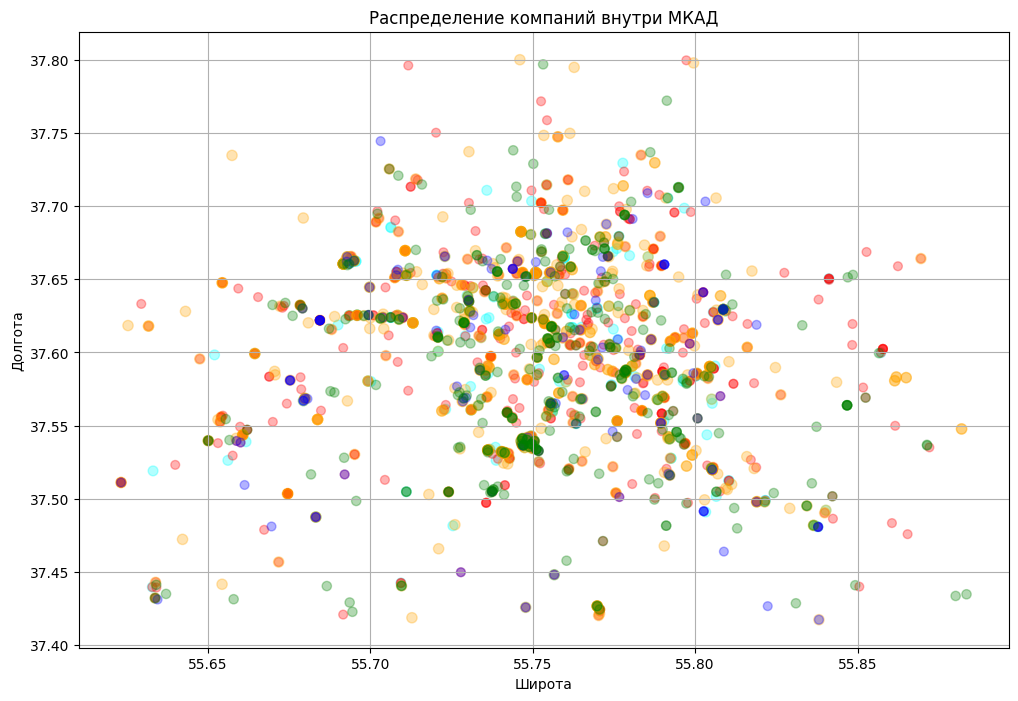

In [109]:
plt.figure(figsize = (12, 8))
plt.scatter(latitudes, longitudes, c = colors, s = volumes, alpha = 0.3)

plt.title('Распределение компаний внутри МКАД')
plt.xlabel('Широта')
plt.ylabel('Долгота')

plt.grid(True)

(1 балл) Нанесите все точки вакансий на карту (для этого вам поможет данная <a target="_blank" href="https://plotly.com/python/mapbox-layers/">документации</a>, не забудьте про прозрачность и центрирование по Москве):

In [ ]:
# your code here

(2 балла) **Сделайте выводы о проделанной работе:**

>*Подсказки для маленьких: Что вы можете сказать про районы Москвы? Что вы можете сказать про зарплаты? Что вы можете сказать про спрос?*

Ваши выводы здесь :)

## Задание 2. Анализ данных - 20 баллов

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [14]:
!gdown 10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8

Downloading...
From: https://drive.google.com/uc?id=10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8
To: /content/diamonds.csv
100% 35.4M/35.4M [00:00<00:00, 224MB/s]


Создадим DataFrame:

In [15]:
import pandas as pd

diamonds = pd.read_csv("diamonds.csv")
diamonds

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,...,8.66,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,1210692
219699,219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,...,5.71,TK,XTK,unknown,NaN,Green,unknown,NaN,Fancy Light,1292500
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,...,10.20,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,1315496
219701,219702,Princess,unknown,SI2,0.90,unknown,GIA,Good,Good,unknown,...,3.47,XTN,VTK,unknown,Faint,Red,unknown,unknown,Fancy,1350000


(0.5 балла) Выведете первые 5 строк датасета:

In [ ]:
diamonds.head()

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200


(0.5 балла) Найдите количество бриллиантов всего в данном датасете:

In [ ]:
len(diamonds)

219703

(0.5 балла) Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

In [ ]:
min_indexes = diamonds[diamonds['total_sales_price'] == diamonds['total_sales_price'].min()].index
print(*min_indexes, end = ' - ')
print(diamonds['total_sales_price'].min())

max_indexes = diamonds[diamonds['total_sales_price'] == diamonds['total_sales_price'].max()].index
print(*max_indexes, end = ' - ')
print(diamonds['total_sales_price'].max())

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 - 200
219702 - 1449881


(1 балл) Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

In [16]:
diamonds.fillna('unknown', inplace = True)
diamonds.stack().value_counts()['unknown']

1891168

(1 балл) Найдите в каких столбцах присутствуют пропуски:

In [ ]:
diamonds.columns[diamonds.eq('unknown').any()].to_list()

['color',
 'cut_quality',
 'eye_clean',
 'culet_size',
 'culet_condition',
 'girdle_min',
 'girdle_max',
 'fluor_color',
 'fluor_intensity',
 'fancy_color_dominant_color',
 'fancy_color_secondary_color',
 'fancy_color_overtone',
 'fancy_color_intensity']

В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными.

Ваша задача:

1. (0.5 балла) найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

In [ ]:
len(diamonds.columns[diamonds.columns.str.startswith('fancy_color') | diamonds.columns.str.startswith('fluor_')].to_list())

6

2. (0.5 балла) найти количество информативных (не `None` или `unknown`) значений в этих колонках:

In [17]:
boring_part = diamonds[diamonds.columns[diamonds.columns.str.startswith('fancy_color') | diamonds.columns.str.startswith('fluor_')]]
boring_part.stack().value_counts().sum() - boring_part.stack().value_counts()['unknown']

111586

3. (0.5 балла) удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

In [18]:
for column_name in boring_part.columns.to_list():
  del diamonds[column_name]

diamonds

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,culet_condition,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,N,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,N,unknown,61.9,59.0,2.84,2.89,1.78,STK,STK,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,unknown,62.0,59.0,2.86,2.88,1.78,M,STK,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,N,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,N,unknown,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219699,219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,unknown,unknown,64.8,65.0,11.55,8.81,5.71,TK,XTK,1292500
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,N,unknown,60.2,59.0,17.06,17.10,10.20,TN,M,1315496
219701,219702,Princess,unknown,SI2,0.90,unknown,GIA,Good,Good,unknown,N,unknown,70.8,72.0,5.22,4.90,3.47,XTN,VTK,1350000


(1 балл) Проделайте тоже самое для колонок, начинающихся с `culet_`:

In [19]:
culet_columns = diamonds.columns[diamonds.columns.str.startswith('culet_')]
culet_part = diamonds[culet_columns]
non_trivial = culet_part.stack().value_counts().sum() - culet_part.stack().value_counts()['unknown']

print(len(culet_columns.to_list()))
print(non_trivial)
print()  # filler

for column_name in culet_columns.to_list():
  del diamonds[column_name]

diamonds

2
149282



,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.9,59.0,2.84,2.89,1.78,STK,STK,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.0,59.0,2.86,2.88,1.78,M,STK,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219699,219700,Radiant,unknown,VS2,5.17,unknown,GIA,Very Good,Very Good,unknown,64.8,65.0,11.55,8.81,5.71,TK,XTK,1292500
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,60.2,59.0,17.06,17.10,10.20,TN,M,1315496
219701,219702,Princess,unknown,SI2,0.90,unknown,GIA,Good,Good,unknown,70.8,72.0,5.22,4.90,3.47,XTN,VTK,1350000


(1 балл) Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

In [ ]:
diamonds['total_sales_price'].sum() / 1000

1517721.991

Немного необоснованных манипуляций.

(1 балл) Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

In [ ]:
diamonds.loc[lambda row: row.index % 2 == 0]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.1,59.0,2.88,2.90,1.77,TN,M,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,64.9,58.5,2.79,2.83,1.82,STK,STK,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
8,8,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,63.5,59.5,2.89,2.92,1.85,STK,TK,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219694,219695,Round,D,IF,12.52,Excellent,HRD,Excellent,Excellent,unknown,62.1,58.0,14.84,14.91,9.24,unknown,unknown,1121792
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347
219698,219699,Round,E,VS1,10.65,Excellent,GIA,Excellent,Excellent,unknown,61.3,58.0,14.06,14.18,8.66,M,STK,1210692
219700,219701,Round,E,VS1,18.07,Excellent,GIA,Excellent,Excellent,unknown,60.2,59.0,17.06,17.10,10.20,TN,M,1315496


(0.5 балла) А теперь с индексами, кратными 6:

In [ ]:
diamonds.loc[lambda row: row.index % 6 == 0]

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,depth_percent,table_percent,meas_length,meas_width,meas_depth,girdle_min,girdle_max,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,62.7,59.0,2.85,2.87,1.79,M,M,200
6,6,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,64.0,57.0,2.85,2.88,1.84,STK,STK,200
12,12,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,61.8,58.5,2.85,2.89,1.77,STK,TK,200
18,18,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,61.0,60.0,2.91,2.92,1.78,M,M,200
24,24,Round,L,I1,0.34,Excellent,IGI,Excellent,Excellent,unknown,0.0,0.0,0.00,0.00,0.00,unknown,unknown,204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219678,219679,Round,G,VS1,10.23,Excellent,GIA,Excellent,Excellent,unknown,62.7,55.0,13.82,13.92,8.69,TN,M,859320
219684,219685,Radiant,unknown,I1,0.89,unknown,GIA,Good,Good,unknown,63.8,57.0,6.44,4.96,3.16,TK,VTK,982560
219690,219691,Round,D,VVS2,10.10,Excellent,GIA,Excellent,Excellent,unknown,59.4,59.0,14.07,14.15,8.39,M,STK,1040739
219696,219697,Oval,H,VS2,18.88,unknown,GIA,Excellent,Excellent,unknown,57.1,55.0,21.34,15.23,8.69,TN,STK,1132347


(1 балл) Выберете из датасета только категорильные признаки и выведете датасет:

In [ ]:
categories: int = 15
diamonds.loc[:, diamonds.nunique() < categories]

,cut,color,clarity,cut_quality,lab,symmetry,polish,eye_clean,girdle_min,girdle_max
0,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,M
1,Round,E,VVS2,Very Good,IGI,Very Good,Very Good,unknown,STK,STK
2,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,TN,M
3,Round,E,VVS2,Excellent,IGI,Very Good,Very Good,unknown,M,STK
4,Round,E,VVS2,Very Good,IGI,Very Good,Excellent,unknown,STK,STK
...,...,...,...,...,...,...,...,...,...,...
219698,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,M,STK
219699,Radiant,unknown,VS2,unknown,GIA,Very Good,Very Good,unknown,TK,XTK
219700,Round,E,VS1,Excellent,GIA,Excellent,Excellent,unknown,TN,M
219701,Princess,unknown,SI2,unknown,GIA,Good,Good,unknown,XTN,VTK


>**Примечание**
>
>Данный датасет можно использовать для задания 3 (с использованием `sklearn`)

(0.5 балла) Выберете столбец с данными о цене бриллиантов и домножите его на тот столбец, только транспонированный, и выведите полученную матрицу:

In [ ]:
# Начальная колонка была очень большой, не хватало оперативки. Так что здесь просто какая-то подтаблица
excellent = diamonds[(diamonds['cut_quality'] == 'Excellent') & (diamonds['symmetry'] == 'Excellent') & (diamonds['polish'] == 'Excellent') & (diamonds['carat_weight'] >= 1)]
matrix = pd.DataFrame(excellent['total_sales_price'].values.reshape(-1, 1) * excellent['total_sales_price'].values)
matrix

,0,1,2,3,4,5,6,7,8,9,...,19544,19545,19546,19547,19548,19549,19550,19551,19552,19553
0,2280100,3433740,3799160,3965260,3986400,3986400,4004520,4016600,3847480,3850500,...,1456419160,1514999610,1550786610,1553981770,1562614440,1571515890,1693905920,1693905920,1828144920,1986398960
1,3433740,5171076,5721384,5971524,6003360,6003360,6030648,6048840,5794152,5798700,...,2193309384,2281529214,2335423014,2340234798,2353235256,2366640486,2550955008,2550955008,2753113608,2991437904
2,3799160,5721384,6330256,6607016,6642240,6642240,6672432,6692560,6410768,6415800,...,2426722256,2524330476,2583959676,2589283532,2603667504,2618499324,2822428672,2822428672,3046101072,3309787936
3,3965260,5971524,6607016,6895876,6932640,6932640,6964152,6985160,6691048,6696300,...,2532819016,2634694686,2696930886,2702487502,2717500344,2732980614,2945825792,2945825792,3179277192,3454492496
4,3986400,6003360,6642240,6932640,6969600,6969600,7001280,7022400,6726720,6732000,...,2546322240,2648741040,2711309040,2716895280,2731988160,2747550960,2961530880,2961530880,3196226880,3472909440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19549,1571515890,2366640486,2618499324,2732980614,2747550960,2747550960,2760039828,2768365740,2651802972,2653884450,...,1003809417324,1044184886829,1068850401129,1071052604853,1077002509716,1083137666121,1167492684288,1167492684288,1260014381388,1369087991544
19550,1693905920,2550955008,2822428672,2945825792,2961530880,2961530880,2974992384,2983966720,2858326016,2860569600,...,1081986332672,1125506253312,1152092723712,1154466435584,1160879720448,1167492684288,1258417291264,1258417291264,1358144600064,1475712888832
19551,1693905920,2550955008,2822428672,2945825792,2961530880,2961530880,2974992384,2983966720,2858326016,2860569600,...,1081986332672,1125506253312,1152092723712,1154466435584,1160879720448,1167492684288,1258417291264,1258417291264,1358144600064,1475712888832
19552,1828144920,2753113608,3046101072,3179277192,3196226880,3196226880,3210755184,3220440720,3084843216,3087264600,...,1167731805072,1214700601212,1243394001612,1245955825884,1252877352048,1260014381388,1358144600064,1358144600064,1465775118864,1592660483232


### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика _(не понимаю, где тут нужна легенда)_
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

(2 балла) Постройте график `цвет бриллианта - стоимость`:

<ipython-input-83-91cc7c0dd919>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced['price_log'] = reduced['total_sales_price'].apply(np.log)


Text(0, 0.5, 'Логарифм цены')

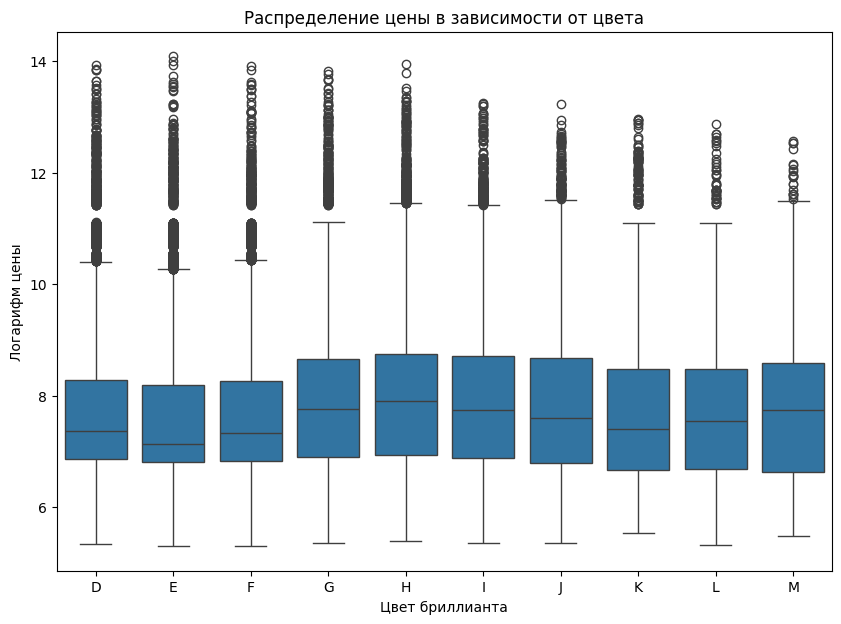

In [83]:
reduced = diamonds.loc[:, ['color', 'total_sales_price']]
reduced = reduced[reduced['color'] != 'unknown']
reduced['price_log'] = reduced['total_sales_price'].apply(np.log)
reduced = reduced.sort_values(by = 'color')

plt.figure(figsize = (10, 7))
sns.boxplot(x='color', y='price_log', data=reduced)
plt.title('Распределение цены в зависимости от цвета')
plt.xlabel('Цвет бриллианта')
plt.ylabel('Логарифм цены')

(2 балла) Постройте график `лабараторная оценка - кол-во бриллиантов`:

Text(0, 0.5, 'Логарифм количества бриллиантов')

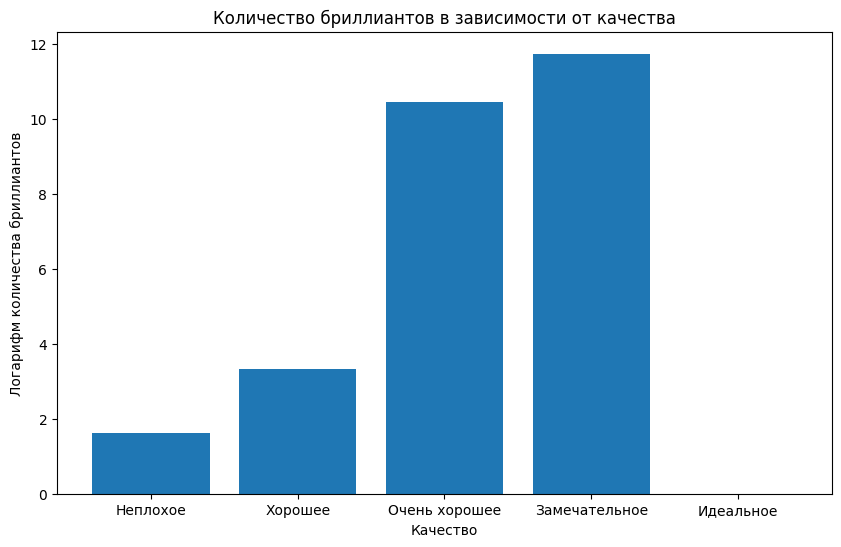

In [84]:
fair = 'Неплохое'
good = 'Хорошее'
very_good = 'Очень хорошее'
excellent = 'Замечательное'
ideal = 'Идеальное'

filtered = diamonds[diamonds['cut_quality'] != 'unknown']
filtered.loc[filtered['cut_quality'] == 'Fair', 'cut_quality'] = fair
filtered.loc[filtered['cut_quality'] == 'Good', 'cut_quality'] = good
filtered.loc[filtered['cut_quality'] == 'Very Good', 'cut_quality'] = very_good
filtered.loc[filtered['cut_quality'] == 'Excellent', 'cut_quality'] = excellent
filtered.loc[filtered['cut_quality'] == 'Ideal', 'cut_quality'] = ideal

reduced = np.log(filtered['cut_quality'].value_counts())
sorted = reduced.loc[[fair, good, very_good, excellent, ideal]]

plt.figure(figsize = (10, 6))
plt.bar(sorted.index, sorted.values)
plt.title('Количество бриллиантов в зависимости от качества')
plt.xlabel('Качество')
plt.ylabel('Логарифм количества бриллиантов')

(2 балла) Постройте график `вес бриллианта - стоимость`:

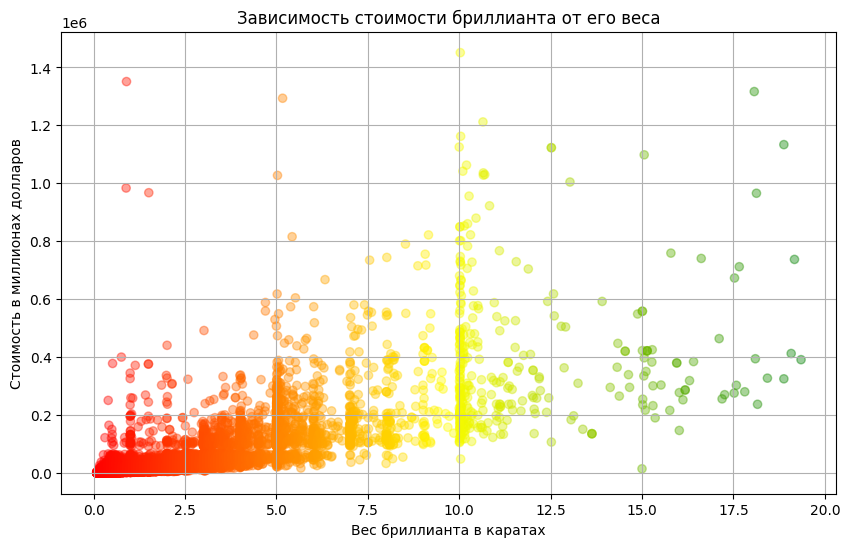

In [112]:
from matplotlib.colors import LinearSegmentedColormap, Normalize

reduced = diamonds.loc[:, ['carat_weight', 'total_sales_price']]
reduced = reduced[reduced['carat_weight'] != 'unknown']
reduced['price_log'] = reduced['total_sales_price'].apply(np.log)
reduced = reduced.sort_values(by = 'carat_weight')

cmap = LinearSegmentedColormap.from_list("", ["red", "yellow", "green"])
normalized = Normalize(vmin = reduced['carat_weight'].min(), vmax = reduced['carat_weight'].max())

plt.figure(figsize = (10, 6))
plt.scatter(reduced['carat_weight'], reduced['total_sales_price'], c = cmap(normalized(reduced['carat_weight'])), alpha = 0.4)
plt.title('Зависимость стоимости бриллианта от его веса')
plt.xlabel('Вес бриллианта в каратах')
plt.ylabel('Стоимость в миллионах долларов')
plt.grid(True)

(2 балла) Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

Text(0, 0.5, 'Логарифм количества бриллиантов')

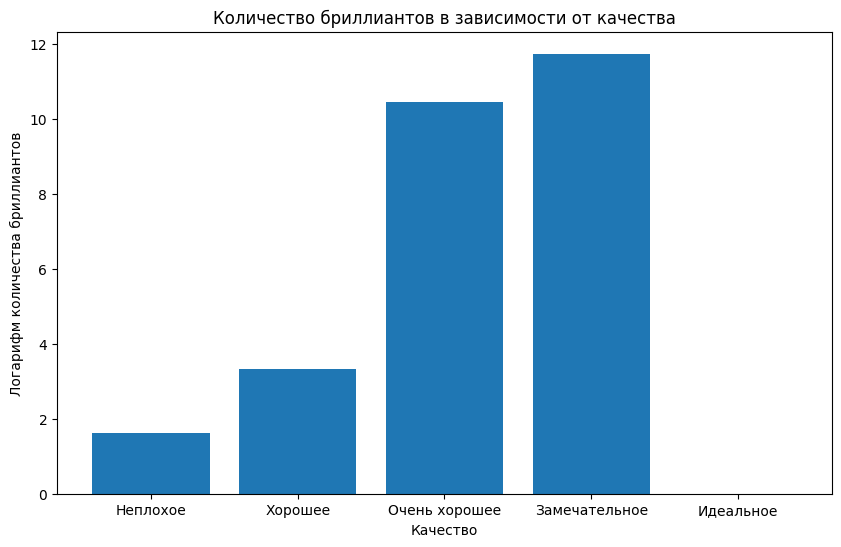

In [81]:
# То же самое, что и во втором графике
fair = 'Неплохое'
good = 'Хорошее'
very_good = 'Очень хорошее'
excellent = 'Замечательное'
ideal = 'Идеальное'

filtered = diamonds[diamonds['cut_quality'] != 'unknown']
filtered.loc[filtered['cut_quality'] == 'Fair', 'cut_quality'] = fair
filtered.loc[filtered['cut_quality'] == 'Good', 'cut_quality'] = good
filtered.loc[filtered['cut_quality'] == 'Very Good', 'cut_quality'] = very_good
filtered.loc[filtered['cut_quality'] == 'Excellent', 'cut_quality'] = excellent
filtered.loc[filtered['cut_quality'] == 'Ideal', 'cut_quality'] = ideal

reduced = np.log(filtered['cut_quality'].value_counts())
sorted = reduced.loc[[fair, good, very_good, excellent, ideal]]

plt.figure(figsize = (10, 6))
plt.bar(sorted.index, sorted.values)
plt.title('Количество бриллиантов в зависимости от качества')
plt.xlabel('Качество')
plt.ylabel('Логарифм количества бриллиантов')

(2 балла) **Сделайте выводы по построенным графикам:**

>*Подсказка для маленьких: Что вы можете сказать о графиках полученных выше для данного датасета?*

### 1. Цвет не влияет на цену бриллианта
На первом графике видно, что зависимость цены камня от его цвета несущественна, все цвета имеют примерно равные цены

### 2. Наиболее востребованы камни качества "Очень хорошее" - "Замечательное"
Бриллианты меньшего качества тоже пользуются спросом, но их производят гораздо меньше. В то время как идеальные бриллианты почти не производятся

### 3. Вес бриллианта незначительно влияет на его цену
Из третьего графика понятно, что цена камня может быть как и достаточно низкой, так и очень высокой вне зависимости от его веса (особенно хорошо видно на выборке весом 10 карат). При этом более тяжелые бриллианты все же по большей части дороже легких


## Задание 3. Модель - 30 баллов

В данном задании вам предстоит построить классифицирующую модель размер алмаза и его стоимости, а затем оценить полученную модель.

>**Примечание**
>
>Данная модель не претендует на самый верный индикатор стоимости алмаза, ведь мы не учитываем ничего больше чем стоимость алмаза. Исключительно для образовательных целей :)

Для построения модели нам понадобится 4 столбца, а именно:
- `meas_length`
- `meas_width`
- `meas_depth`
- `total_sales_price`

От остальных столбцов можно избавиться.

(1 балл) Создайте новый датасет и выведите его первые 10 строк:

In [115]:
save = ['meas_length', 'meas_width', 'meas_depth', 'total_sales_price']
diamonds = diamonds[diamonds.columns[diamonds.columns.isin(save)]]
diamonds.head(10)

,meas_length,meas_width,meas_depth,total_sales_price
0,2.85,2.87,1.79,200
1,2.84,2.89,1.78,200
2,2.88,2.90,1.77,200
3,2.86,2.88,1.78,200
4,2.79,2.83,1.82,200
5,2.95,2.99,1.81,200
6,2.85,2.88,1.84,200
7,2.86,2.89,1.78,200
8,2.89,2.92,1.85,200
9,2.83,2.87,1.80,200


(1 балл) Перемешайте строки в датафрейме случайным образом:

In [118]:
diamonds = diamonds.sample(frac = 1)
diamonds

,meas_length,meas_width,meas_depth,total_sales_price
121987,5.11,5.18,3.05,2460
85703,4.49,4.51,2.80,1248
90918,4.42,3.06,2.31,1350
31096,4.63,4.65,2.98,818
60312,4.35,4.37,2.71,1002
...,...,...,...,...
146677,7.76,5.30,3.49,3630
194198,8.36,6.29,4.20,12399
11995,5.88,3.97,2.40,654
8848,4.32,2.78,1.95,592


(1 балл) Сформируем новую колонку - для каждого бриллианта найдем сумму Минковского (p=3) по 3 измерениям бриллианта:

In [120]:
# Сумму Минковского считаем как корень 3 степени из суммы кубов
diamonds['sum'] = diamonds.apply(lambda row: (row['meas_length']**3 + row['meas_width']**3 + row['meas_depth']**3)**(1/3), axis = 1)
diamonds

,meas_length,meas_width,meas_depth,total_sales_price,sum
121987,5.11,5.18,3.05,2460,6.700255
85703,4.49,4.51,2.80,1248,5.888734
90918,4.42,3.06,2.31,1350,5.030874
31096,4.63,4.65,2.98,818,6.093544
60312,4.35,4.37,2.71,1002,5.704878
...,...,...,...,...,...
146677,7.76,5.30,3.49,3630,8.700754
194198,8.36,6.29,4.20,12399,9.680655
11995,5.88,3.97,2.40,654,6.539735
8848,4.32,2.78,1.95,592,4.784461


(1 балл) Сформируем новый датасет из двух колонок - сумма Минковского и `total_sales_price`:

In [121]:
data = diamonds.loc[:, ['sum', 'total_sales_price']]
data

,sum,total_sales_price
121987,6.700255,2460
85703,5.888734,1248
90918,5.030874,1350
31096,6.093544,818
60312,5.704878,1002
...,...,...
146677,8.700754,3630
194198,9.680655,12399
11995,6.539735,654
8848,4.784461,592


(1 балл) Разделите вашу выборку на две части в соотношении 8:2 - одна выборка будет для тренировка, а другая для тестов вашей модели:

In [123]:
size: int = int(len(data) * 4 / 5)
training = data.head(size)
testing = data.iloc[size:]

print(training)
print(testing)

             sum  total_sales_price
121987  6.700255               2460
85703   5.888734               1248
90918   5.030874               1350
31096   6.093544                818
60312   5.704878               1002
...          ...                ...
51376   5.132220                936
8477    5.622218                586
20073   5.725671                730
193650  8.373710              11693
163141  0.000000               5256

[175762 rows x 2 columns]
              sum  total_sales_price
113049   5.949096               2016
142007   6.620649               3432
25102    5.626739                772
198232   9.930830              14566
209081  10.885497              28143
...           ...                ...
146677   8.700754               3630
194198   9.680655              12399
11995    6.539735                654
8848     4.784461                592
76650    5.731530               1114

[43941 rows x 2 columns]


(2 балла) Постройте график зависимости стоимости от вашего нового параметра размера для тренинг-выборки:

In [ ]:
# your code here

(2 балла) Нанесите на тот же график тестовую выборку, используя другой цвет (не забудьте про параметр прозрачности):

In [ ]:
# your code here

(3 балла) Найдите для каждой бриллианта из тестовой выборки его "ближайшего соседа" из тренинг-выборки. Для каждого бриллианта из тестовой выборки найдите расстояния до соответствующего ближайшего соседа:

In [ ]:
# your code here

(3 балла) Найдите насколько сильно (в процентах) отличается цена бриллиантов из тестовой выборки от их соответствующих ближайших соседей:

In [ ]:
# your code here

**Данная модель является выдумкой автора. Не важен коэффициент ошибки, важны ваши шаги для получения коэффициента.**

### Введение в машинное обучение

Теперь давайте познакомимся с таким сильным инструментом как `sklearn`.

Вам необходимо:
1. выбрать 2 категориальных признака
2. на их основе обучить решающее дерево
3. оценить среднеквадратичную ошибку цены бриллианта
4. сделать пп. 1-3 и выбрать ту пару, которая дает лучший результат
5. сделать выводы

(3 балла) Мы работаем с категориальными признаками, для них не понятно что есть "больше" и "меньше". Поэтому нам нужно предварительно закодировать значения наших признаков, с чем нам поможет [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html):

In [ ]:
# your code here

(3 балла) Разбейте датасет на обучающую и тестовую выбору. Для этого вам поможет [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html):

In [ ]:
# your code here

(3 балла) Затем создайте и обучите вашу модель - [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html):

In [ ]:
# your code here

(3 балла) Оцените ошибку вашей модели при помощи [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html):

In [ ]:
# your code here

(3 балла) **Сделайте выводы какие категориальные признаки лучше:**

*Подсказки для маленьких: Что вы можете сказать о зависимости по вашей выборке признаков? Какой вы можете сделать вывод об готовых инструментах для работы и написанных Вами?*

Ваши выводы здесь :)